# Compare GPs + Plot

In [1]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot
import tueplots.figsizes

In [2]:
device = "cpu"
if device!="mps":
    torch.set_default_dtype(torch.float64)

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]

## True Function

In [4]:
d = 1
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768):
    # https://www.sfu.ca/~ssurjano/ackley.html
    assert x.ndim==2
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y

## Parameters

In [5]:
n = 2**2
xticks = torch.linspace(0,1,501,device=device)
yticks = f_ackley(xticks[:,None])

## Standard GP

In [6]:
print("  n = %d"%n)
sgp = fastgps.StandardGP(
    qp.KernelSquaredExponential(d,torchify=True,device=device),
    qp.DigitalNetB2(d,seed=11),
    )
x_next = sgp.get_x_next(n)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_n,pstd_std_n,q,ci_low_std_n,ci_high_std_n = sgp.post_ci(xticks[:,None])
x_std_n,y_std_n = sgp.x.clone(),sgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (sgp.post_cubature_var(),2*n,sgp.post_cubature_var(n=2*n),4*n,sgp.post_cubature_var(n=4*n)))

  n = 4
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.06e+05   | 1.06e+05  
            5.00e+00 | 2.49e+03   | 2.49e+03  
            1.00e+01 | 1.14e+01   | 1.14e+01  
            1.50e+01 | 1.13e+01   | 1.14e+01  
            2.00e+01 | 1.13e+01   | 1.13e+01  
            2.30e+01 | 1.13e+01   | 1.13e+01  
    posterior cubature var: 1.11e-01   n=8: 1.08e-01   n=16: 1.02e-01  


In [7]:
print("  n = %d"%(2*n))
x_next = sgp.get_x_next(2*n)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_2n,pstd_std_2n,q,ci_low_std_2n,ci_high_std_2n = sgp.post_ci(xticks[:,None])
x_std_2n,y_std_2n = sgp.x.clone(),sgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (sgp.post_cubature_var(),4*n,sgp.post_cubature_var(n=4*n),8*n,sgp.post_cubature_var(n=8*n)))

  n = 8
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.16e+01   | 2.16e+01  
            5.00e+00 | 2.15e+01   | 2.15e+01  
            1.00e+01 | 2.10e+01   | 2.10e+01  
            1.50e+01 | 2.09e+01   | 2.09e+01  
            2.00e+01 | 2.09e+01   | 2.09e+01  
            2.20e+01 | 2.09e+01   | 2.09e+01  
    posterior cubature var: 5.59e-01   n=16: 9.60e-02   n=32: 2.72e-03  


In [8]:
print("  n = %d"%(4*n))
x_next = sgp.get_x_next(4*n)
assert x_next.shape==(2*n,1)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_4n,pstd_std_4n,q,ci_low_std_4n,ci_high_std_4n = sgp.post_ci(xticks[:,None])
x_std_4n,y_std_4n = sgp.x.clone(),sgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (sgp.post_cubature_var(),8*n,sgp.post_cubature_var(n=8*n),16*n,sgp.post_cubature_var(n=16*n)))

  n = 16
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.34e+01   | 4.34e+01  
            5.00e+00 | 4.06e+01   | 4.06e+01  
            1.00e+01 | 4.06e+01   | 4.06e+01  
            1.50e+01 | 4.06e+01   | 4.06e+01  
            2.00e+01 | 4.06e+01   | 4.06e+01  
            2.40e+01 | 4.06e+01   | 4.06e+01  
    posterior cubature var: 9.88e-03   n=32: 1.58e-05   n=64: 1.59e-06  


## Lattice

In [9]:
print("  n = %d"%n)
fgp = fastgps.FastGPLattice(
    qp.KernelShiftInvar(d,torchify=True,device=device),
    qp.Lattice(d,seed=7),
    )
x_next = fgp.get_x_next(n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_n,pstd_lattice_n,q,ci_low_lattice_n,ci_high_lattice_n = fgp.post_ci(xticks[:,None])
x_lattice_n,y_lattice_n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),2*n,fgp.post_cubature_var(n=2*n),4*n,fgp.post_cubature_var(n=4*n)))

  n = 4
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 5.11e+01   | 5.11e+01  
            5.00e+00 | 1.83e+01   | 1.83e+01  
            1.00e+01 | 1.28e+01   | 1.28e+01  
            1.50e+01 | 1.27e+01   | 1.27e+01  
            2.00e+01 | 1.26e+01   | 1.26e+01  
            2.50e+01 | 1.26e+01   | 1.26e+01  
            3.00e+01 | 1.24e+01   | 1.24e+01  
            3.50e+01 | 1.22e+01   | 1.22e+01  
            4.00e+01 | 1.19e+01   | 1.19e+01  
            4.50e+01 | 1.15e+01   | 1.15e+01  
            5.00e+01 | 1.14e+01   | 1.15e+01  
            5.50e+01 | 1.14e+01   | 1.14e+01  
            5.60e+01 | 1.14e+01   | 1.14e+01  
    posterior cubature var: 1.89e-02   n=8: 7.62e-03   n=16: 7.24e-04  


In [10]:
print("  n = %d"%(2*n))
x_next = fgp.get_x_next(2*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_2n,pstd_lattice_2n,q,ci_low_lattice_2n,ci_high_lattice_2n = fgp.post_ci(xticks[:,None])
x_lattice_2n,y_lattice_2n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),4*n,fgp.post_cubature_var(n=4*n),8*n,fgp.post_cubature_var(n=8*n)))

  n = 8
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.93e+01   | 1.93e+01  
            5.00e+00 | 1.90e+01   | 1.90e+01  
            1.00e+01 | 1.90e+01   | 1.90e+01  
            1.50e+01 | 1.89e+01   | 1.89e+01  
            2.00e+01 | 1.89e+01   | 1.89e+01  
            2.50e+01 | 1.89e+01   | 1.89e+01  
            2.60e+01 | 1.89e+01   | 1.89e+01  
    posterior cubature var: 3.24e-03   n=16: 6.17e-04   n=32: 4.42e-05  


In [11]:
print("  n = %d"%(4*n))
x_next = fgp.get_x_next(4*n)
assert x_next.shape==(2*n,1)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_4n,pstd_lattice_4n,q,ci_low_lattice_4n,ci_high_lattice_4n = fgp.post_ci(xticks[:,None])
x_lattice_4n,y_lattice_4n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),8*n,fgp.post_cubature_var(n=8*n),16*n,fgp.post_cubature_var(n=16*n)))

  n = 16
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.43e+01   | 4.43e+01  
            5.00e+00 | 3.66e+01   | 3.70e+01  
            1.00e+01 | 3.66e+01   | 3.66e+01  
            1.40e+01 | 3.66e+01   | 3.66e+01  
    posterior cubature var: 1.70e-03   n=32: 1.35e-04   n=64: 8.59e-06  


## Digital Net

In [12]:
print("  n = %d"%n)
fgp = fastgps.FastGPDigitalNetB2(
    qp.KernelDigShiftInvar(d,torchify=True,device=device),
    qp.DigitalNetB2(d,seed=7),
    )
x_next = fgp.get_x_next(n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_n,pstd_dnb2_n,q,ci_low_dnb2_n,ci_high_dnb2_n = fgp.post_ci(xticks[:,None])
x_dnb2_n,y_dnb2_n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),2*n,fgp.post_cubature_var(n=2*n),4*n,fgp.post_cubature_var(n=4*n)))

  n = 4
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.71e+01   | 4.71e+01  
            5.00e+00 | 1.73e+01   | 1.73e+01  
            1.00e+01 | 1.27e+01   | 1.27e+01  
            1.50e+01 | 1.27e+01   | 1.27e+01  
            2.00e+01 | 1.26e+01   | 1.26e+01  
            2.50e+01 | 1.26e+01   | 1.26e+01  
    posterior cubature var: 2.13e+00   n=8: 9.29e-01   n=16: 2.80e-01  


In [13]:
print("  n = %d"%(2*n))
x_next = fgp.get_x_next(2*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_2n,pstd_dnb2_2n,q,ci_low_dnb2_2n,ci_high_dnb2_2n = fgp.post_ci(xticks[:,None])
x_dnb2_2n,y_dnb2_2n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),4*n,fgp.post_cubature_var(n=4*n),8*n,fgp.post_cubature_var(n=8*n)))

  n = 8
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.72e+01   | 2.72e+01  
            5.00e+00 | 2.66e+01   | 2.66e+01  
            1.00e+01 | 2.65e+01   | 2.65e+01  
            1.20e+01 | 2.65e+01   | 2.65e+01  
    posterior cubature var: 1.39e+00   n=16: 4.49e-01   n=32: 3.26e-01  


In [14]:
print("  n = %d"%(4*n))
x_next = fgp.get_x_next(4*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_4n,pstd_dnb2_4n,q,ci_low_dnb2_4n,ci_high_dnb2_4n = fgp.post_ci(xticks[:,None])
x_dnb2_4n,y_dnb2_4n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),8*n,fgp.post_cubature_var(n=8*n),16*n,fgp.post_cubature_var(n=16*n)))

  n = 16
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.84e+01   | 4.84e+01  
            5.00e+00 | 4.75e+01   | 4.75e+01  
            1.00e+01 | 4.74e+01   | 4.74e+01  
            1.50e+01 | 4.74e+01   | 4.74e+01  
            2.00e+01 | 4.74e+01   | 4.74e+01  
            2.50e+01 | 4.73e+01   | 4.73e+01  
            3.00e+01 | 4.71e+01   | 4.71e+01  
            3.50e+01 | 4.68e+01   | 4.68e+01  
            4.00e+01 | 4.63e+01   | 4.63e+01  
            4.50e+01 | 4.63e+01   | 4.67e+01  
            5.00e+01 | 4.62e+01   | 4.62e+01  
            5.10e+01 | 4.62e+01   | 4.63e+01  
    posterior cubature var: 1.77e-02   n=32: 1.73e-02   n=64: 6.37e-03  


## Collect Data + Plot

In [15]:
data = [
    [
        (x_std_n,y_std_n,pmean_std_n,ci_low_std_n,ci_high_std_n),
        (x_lattice_n,y_lattice_n,pmean_lattice_n,ci_low_lattice_n,ci_high_lattice_n),
        (x_dnb2_n,y_dnb2_n,pmean_dnb2_n,ci_low_dnb2_n,ci_high_dnb2_n)
    ],
    [   
        (x_std_2n,y_std_2n,pmean_std_2n,ci_low_std_2n,ci_high_std_2n),
        (x_lattice_2n,y_lattice_2n,pmean_lattice_2n,ci_low_lattice_2n,ci_high_lattice_2n),
        (x_dnb2_2n,y_dnb2_2n,pmean_dnb2_2n,ci_low_dnb2_2n,ci_high_dnb2_2n)
    ],
    [   
        (x_std_4n,y_std_4n,pmean_std_4n,ci_low_std_4n,ci_high_std_4n),
        (x_lattice_4n,y_lattice_4n,pmean_lattice_4n,ci_low_lattice_4n,ci_high_lattice_4n),
        (x_dnb2_4n,y_dnb2_4n,pmean_dnb2_4n,ci_low_dnb2_4n,ci_high_dnb2_4n)
    ],
]

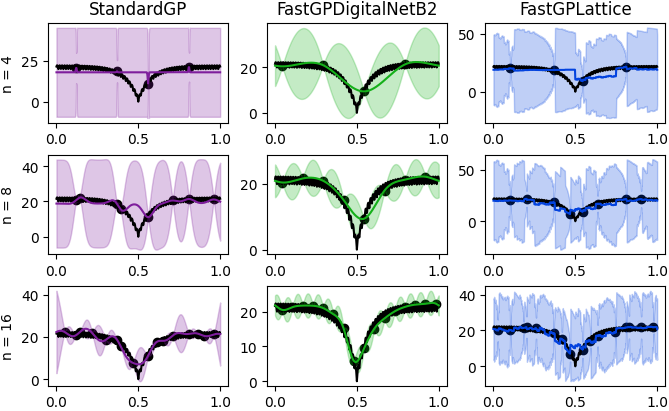

In [16]:
nrows = 3
ncols = len(data[0])
_alpha = 0.25
pyplot.rcParams.update(tueplots.figsizes.icml2024_full(nrows=nrows,ncols=ncols))
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols)
ax = ax.reshape((nrows,ncols))
for i in range(3):
    for j in range(ncols):
        x,y,pmean,ci_low,ci_high = data[i][j]
        ax[i,j].plot(xticks.cpu(),yticks.cpu(),color="k")
        ax[i,j].scatter(x[:,0].cpu(),y.cpu(),color="k")
        ax[i,j].plot(xticks.cpu(),pmean.cpu(),color=colors[j])
        ax[i,j].fill_between(xticks.cpu(),ci_low.cpu(),ci_high.cpu(),color=colors[j],alpha=_alpha)
ax[0,0].set_title("StandardGP")
ax[0,1].set_title("FastGPDigitalNetB2")
ax[0,2].set_title("FastGPLattice")
ax[0,0].set_ylabel(r"n = %d"%n)
ax[1,0].set_ylabel(r"n = %d"%(2*n))
ax[2,0].set_ylabel(r"n = %d"%(4*n))
fig.savefig("./gps.pdf")